# King County House Sales Regression Analysis
## Preprocessing and Exploring Data

* Student name: Spencer Hadel
* Student pace: Flex
* Scheduled project review date/time: ________________________
* Instructor name: Claude Fried

#### Objective

In order to help a new real estate company in King County, we need to analyze past house sales data in the region and create a linear regression model which can help the company better understand what factors contribute to price of a given home. We will import just over 21 thousand data points from recent sales in the King County area, and proceed to clean, preprocess, and model the information present in this dataset in order to inform the new company on how to appropriately assess the value of a home when helping a client buy or sell a home.

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

### Import Prepared Data from kc_data_cleaning.ipynb

We have already cleaned the King County Housing Data in the kc_data_cleaning notebook:

[Data Cleaning Notebook](./kc_data_cleaning.ipynb)

We only need the cleaned_df dataframe from it, imported below:

In [2]:
df = pd.read_csv('./data/cleaned.csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21534 non-null  float64
 1   bedrooms        21534 non-null  int64  
 2   bathrooms       21534 non-null  float64
 3   sqft_living     21534 non-null  int64  
 4   sqft_lot        21534 non-null  int64  
 5   floors          21534 non-null  float64
 6   waterfront      21534 non-null  object 
 7   view            21534 non-null  object 
 8   condition       21534 non-null  object 
 9   grade           21534 non-null  object 
 10  sqft_basement   21534 non-null  float64
 11  yr_built        21534 non-null  int64  
 12  zipcode         21534 non-null  int64  
 13  lat             21534 non-null  float64
 14  long            21534 non-null  float64
 15  has_basement    21534 non-null  object 
 16  renovated_2000  21534 non-null  int64  
dtypes: float64(6), int64(6), object

## Exploring Data

Next we need to look through the data and create visualizations for each feature compared to our target variable, price.

### Identifying Types of Data

We need to find out which of the features contain categorical data. It is important to identify this because we want our model to be trained on normalized numerical values, not human concepts like condition scores. The most obvious categorical variables above are the ones where the dtype is an object. We will investigate all the different features in our dataset below.

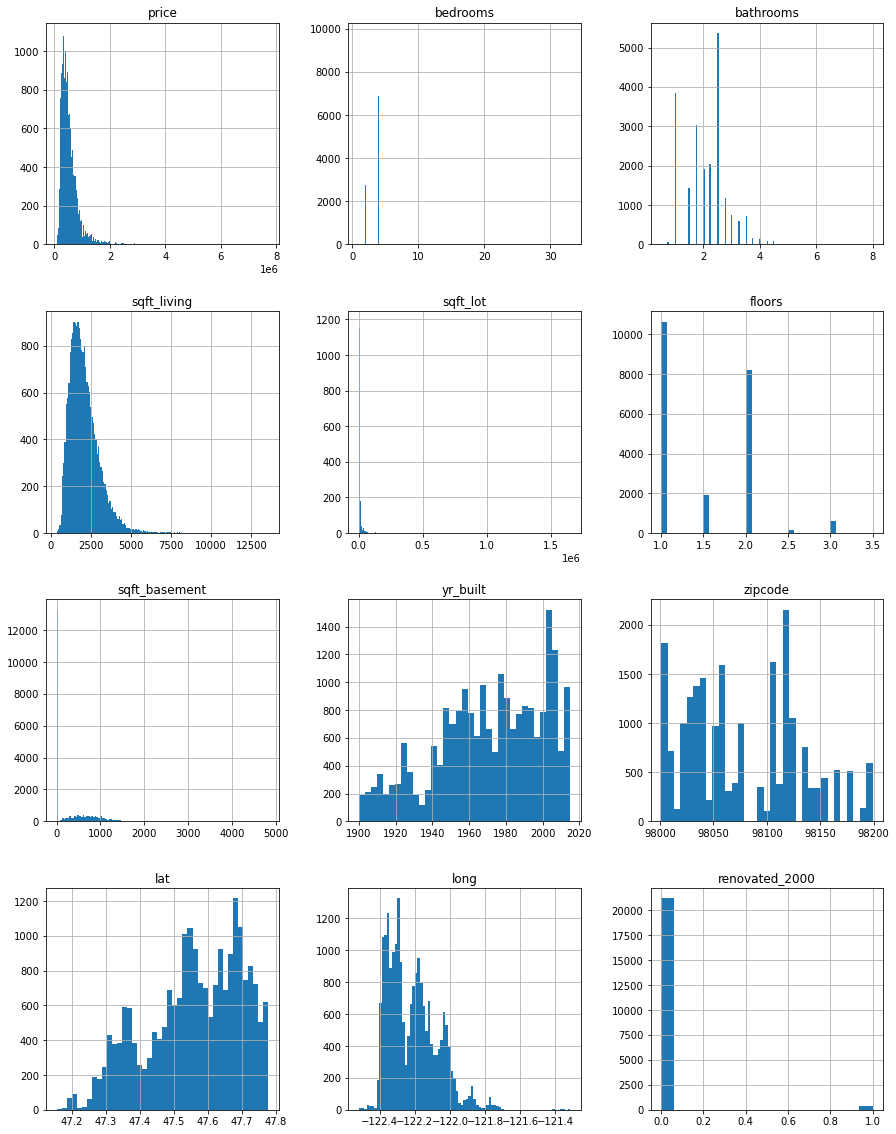

In [4]:
df.hist(figsize=[15,20], bins='auto');

<AxesSubplot:>

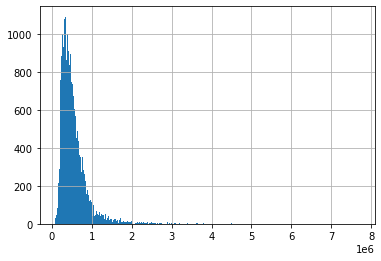

In [5]:
df['price'].hist(bins='auto')  ## MAKE PRETTY########################################

# overall price distribution#######################################3

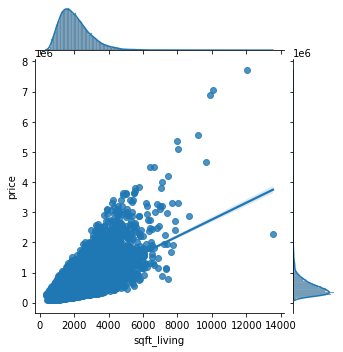

In [6]:
sns.jointplot(x='sqft_living',y='price', data=df, kind='reg', height=5);

In [7]:
#Strong linear connection between sqft_living and price)

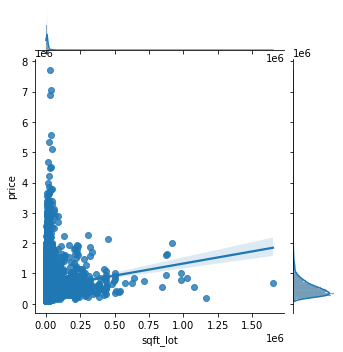

In [8]:
sns.jointplot(x='sqft_lot',y='price', data=df, kind='reg', height=5);

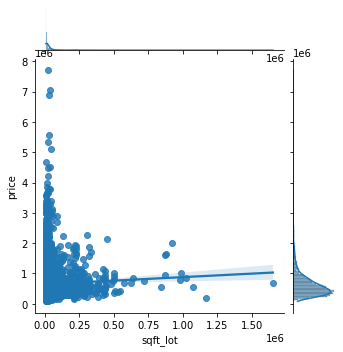

In [9]:
sns.jointplot(x='sqft_lot',y='price', data=df[df['sqft_lot']>10000], kind='reg', height=5);

In [10]:
#Much less evidence of linearity here, if any

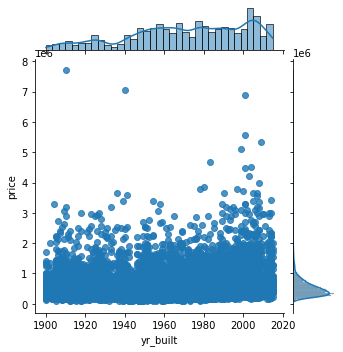

In [11]:
sns.jointplot(x='yr_built',y='price', data=df, kind='reg', height=5);

In [12]:
#No recognizeable linear connection between yr_built and price.

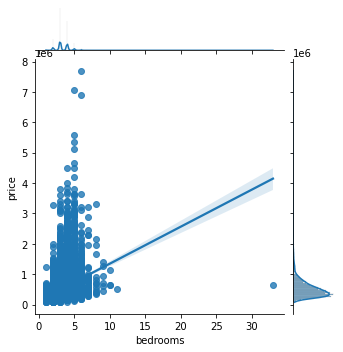

In [13]:
sns.jointplot(x='bedrooms',y='price', data=df, kind='reg', height=5);

In [14]:
#There is a clear outlier in this plot, and drastic outliers such as this can cause problems in our model.

df['bedrooms'].value_counts()

3     9791
4     6865
2     2754
5     1596
6      270
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

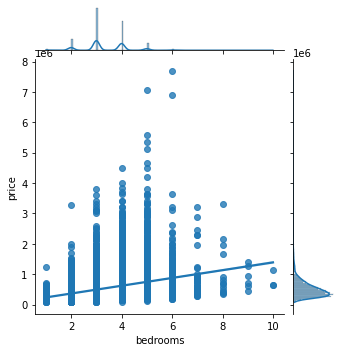

In [15]:
df = df[df['bedrooms']<=10]

sns.jointplot(x='bedrooms',y='price', data=df, kind='reg', height=5);

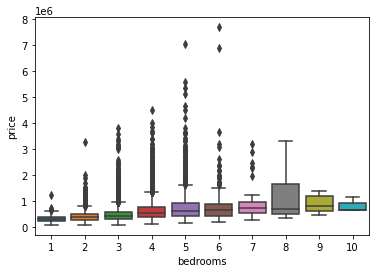

In [16]:
sns.boxplot(x='bedrooms',y='price', data=df);

In [17]:
#There is certainly some sort of interaction between price and number of bedrooms.

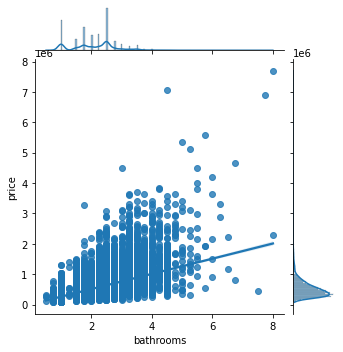

In [18]:
sns.jointplot(x='bathrooms',y='price', data=df, kind='reg', height=5);

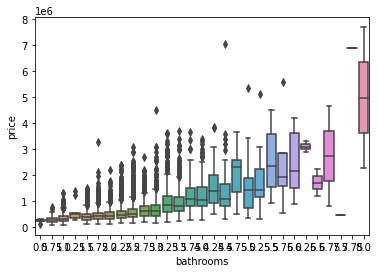

In [19]:
sns.boxplot(x='bathrooms',y='price', data=df);

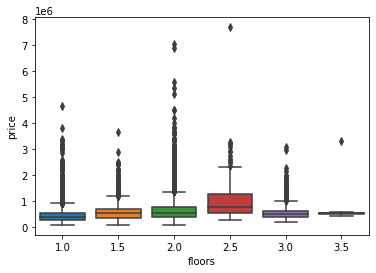

In [20]:
sns.boxplot(x='floors',y='price', data=df);

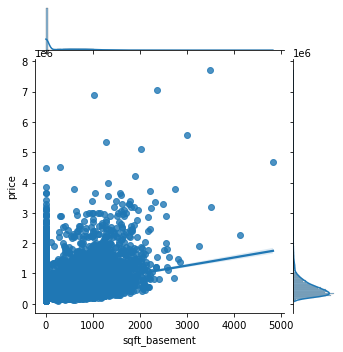

In [21]:
sns.jointplot(x='sqft_basement',y='price', data=df, kind='reg', height=5);

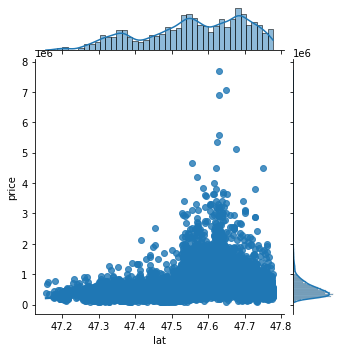

In [22]:
sns.jointplot(x='lat',y='price', data=df, kind='reg', height=5);

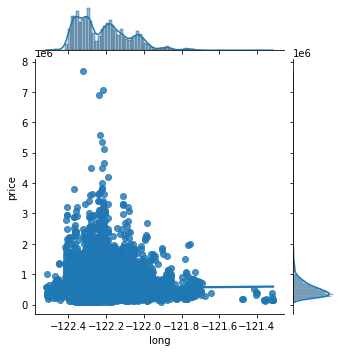

In [23]:
sns.jointplot(x='long',y='price', data=df, kind='reg', height=5);

lat and long could be potentially harmful variables to our feature set, since the numerical values of latitute and longitude are not measureable amounts but rather point to real world locations, which can be influenced by a variety of other factors. Viewed together, however, we get an interesting result.

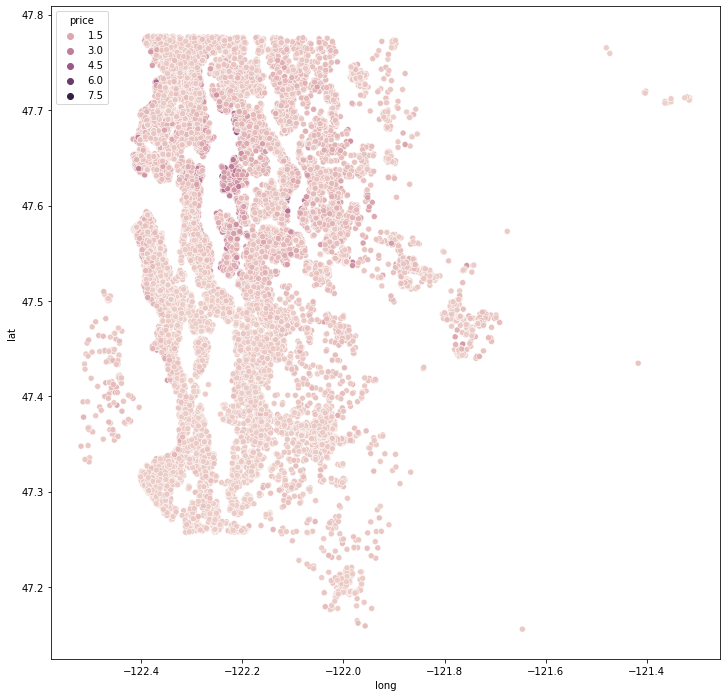

In [24]:
fig = plt.gcf()
fig.set_size_inches(12, 12)
sns.scatterplot(x='long',y='lat',hue='price', data=df);


This is an interesting visualization of the layout of homes in King County, and futre analysis could use this to help identify additional features based on location which influence house value.

# MAKE PRETTY! ALL! !############

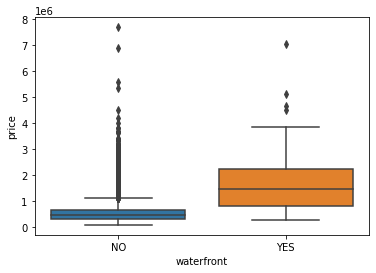

In [25]:
sns.boxplot(x='waterfront',y='price', data=df);

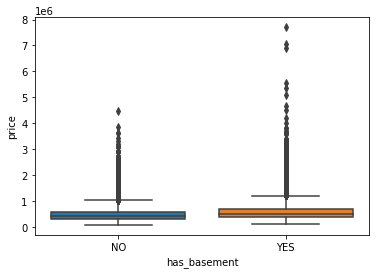

In [26]:
sns.boxplot(x='has_basement',y='price', data=df);

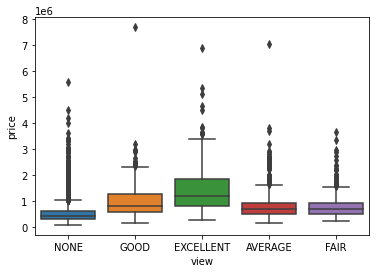

In [27]:
sns.boxplot(x='view',y='price', data=df);

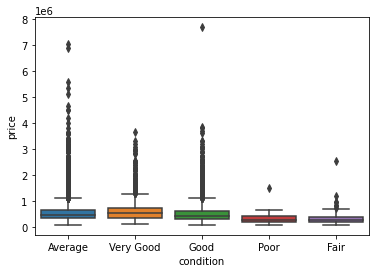

In [28]:
sns.boxplot(x='condition',y='price', data=df);

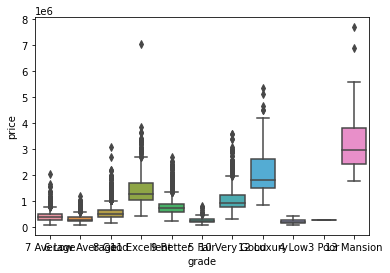

In [29]:
sns.boxplot(x='grade',y='price', data=df);

For the above features (view, grade, and condition), we could just seperate each feature into separate dummies so our model can use them, but instead we will do the slightly more precise task of assigning the different options to number variables. We will do this because it is possible for each of these features to be interpreted numerically instead.

In [30]:
print(df['grade'].unique())
print(df['view'].unique())
print(df['condition'].unique())

['7 Average' '6 Low Average' '8 Good' '11 Excellent' '9 Better' '5 Fair'
 '10 Very Good' '12 Luxury' '4 Low' '3 Poor' '13 Mansion']
['NONE' 'GOOD' 'EXCELLENT' 'AVERAGE' 'FAIR']
['Average' 'Very Good' 'Good' 'Poor' 'Fair']


In [31]:
df['num_grade'] = pd.to_numeric(df['grade'].str[:2])

view_to_num = {'NONE': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
df['num_view'] = df['view'].apply(lambda x: view_to_num.get(x))

cond_to_num = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
df['num_cond'] = df['condition'].apply(lambda x: cond_to_num.get(x))

print(df['num_grade'].unique())
print(df['num_view'].unique())
print(df['num_cond'].unique())

[ 7  6  8 11  9  5 10 12  4  3 13]
[1 4 5 3 2]
[3 5 4 1 2]


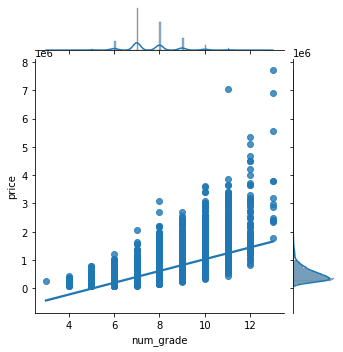

In [32]:
sns.jointplot(x='num_grade',y='price', data=df, kind='reg', height=5);

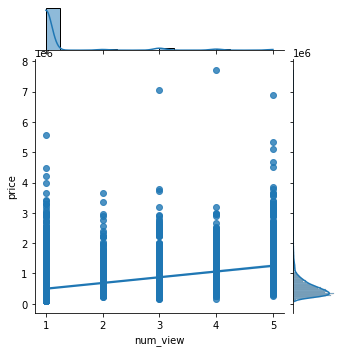

In [33]:
sns.jointplot(x='num_view',y='price', data=df, kind='reg', height=5);

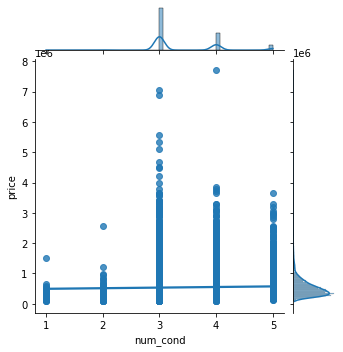

In [34]:
sns.jointplot(x='num_cond',y='price', data=df, kind='reg', height=5);

Now that we have changed these to numbers, we can see which features actually have a linear relationship with the price!

#### One-Hot Encoding Categoricals with Dummy Variables

We need to use one-hot encoding to split the remaining object features into data useable by our model by creating dummy variables for any feature that has mukuoke categorical outcomes.

In [35]:
categorical_df = df[['renovated_2000', 'waterfront', 'has_basement', 'view', 'grade', 'condition']].astype(str)

In [36]:
dummies_df = pd.get_dummies(categorical_df, drop_first=True)
dummies_df.rename(columns={'renovated_2000_1':'renovated', 'waterfront_YES':'waterfront', 'has_basement_YES':'has_basement'}, inplace=True)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21532 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   renovated            21532 non-null  uint8
 1   waterfront           21532 non-null  uint8
 2   has_basement         21532 non-null  uint8
 3   view_EXCELLENT       21532 non-null  uint8
 4   view_FAIR            21532 non-null  uint8
 5   view_GOOD            21532 non-null  uint8
 6   view_NONE            21532 non-null  uint8
 7   grade_11 Excellent   21532 non-null  uint8
 8   grade_12 Luxury      21532 non-null  uint8
 9   grade_13 Mansion     21532 non-null  uint8
 10  grade_3 Poor         21532 non-null  uint8
 11  grade_4 Low          21532 non-null  uint8
 12  grade_5 Fair         21532 non-null  uint8
 13  grade_6 Low Average  21532 non-null  uint8
 14  grade_7 Average      21532 non-null  uint8
 15  grade_8 Good         21532 non-null  uint8
 16  grade_9 Better       2

### Continuous Data

The remaining features are continuous numerical data. We will not include the price feature going forward with the transformations, as it is the feature we want to train our model to predict.

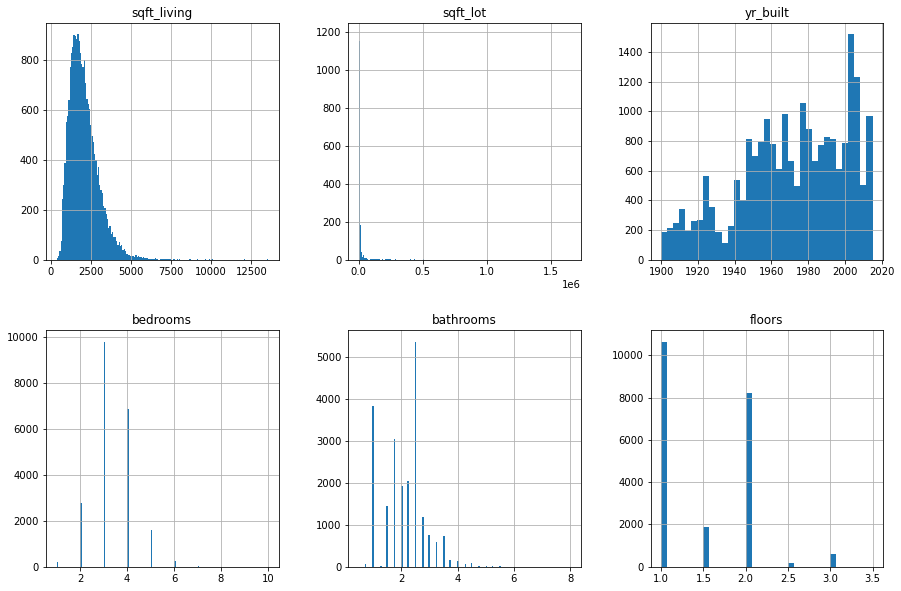

In [37]:
continuous_df = df[['sqft_living','sqft_lot', 'yr_built', 'bedrooms', 'bathrooms', 'floors']]

continuous_df.hist(figsize=[15,10], bins='auto', layout=(2,3));

### Transforming and Standardizing Data

This data is extremely skewed, so we will use the log transform to make the data more normally distributed.

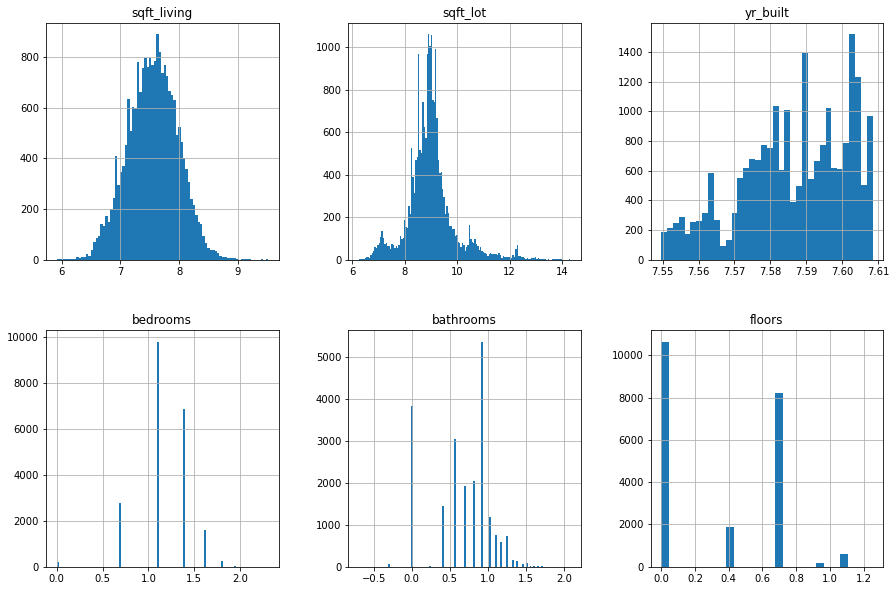

In [38]:
continuous_log = np.log(continuous_df)
continuous_log.hist(figsize=[15,10], bins='auto', layout=(2,3));

Now that the data has been transformed, we standardize it in order to properly scale the continuous features in relation to each other.

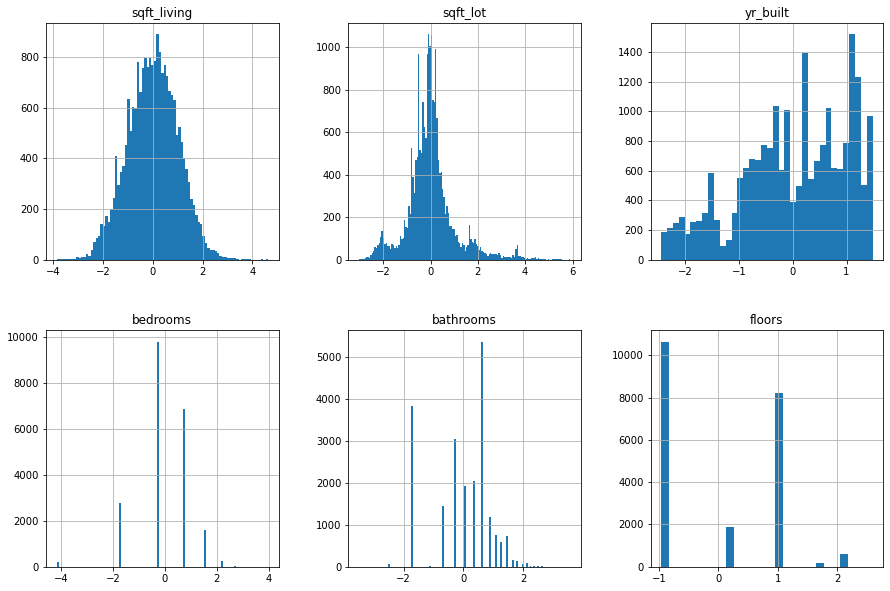

In [39]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
#normalize data

normalized_cont = continuous_log.apply(normalize)
normalized_cont.hist(figsize=[15,10], bins='auto', layout=(2,3));

### Final Preprocessed Dataset
Finally, we combine the continuous and categorical features back into a final preprocessed dataset. This will be composed of the  preprocessed continuous variables, and the categorical dummies, as well as the prices for each entry.

In [40]:
final_df = pd.concat([df['price'], normalized_cont, dummies_df], axis=1)

final_df.describe()

,price,sqft_living,sqft_lot,yr_built,bedrooms,bathrooms,floors,renovated,waterfront,has_basement,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Fair,condition_Good,condition_Poor,condition_Very Good
count,2.153200e+04,2.153200e+04,2.153200e+04,2.153200e+04,2.153200e+04,2.153200e+04,2.153200e+04,21532.000000,21532.000000,21532.000000,...,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000,21532.000000
mean,5.400540e+05,2.005949e-13,-3.830337e-14,3.321620e-11,2.642076e-13,-2.413860e-13,-7.488061e-14,0.017602,0.006734,0.384637,...,0.001254,0.011239,0.094325,0.415475,0.281116,0.120936,0.007895,0.262725,0.001347,0.078766
std,3.660759e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.131502,0.081787,0.486521,...,0.035390,0.105420,0.292287,0.492815,0.449555,0.326061,0.088506,0.440125,0.036675,0.269380
min,7.800000e+04,-3.859348e+00,-3.032021e+00,-2.445305e+00,-4.165512e+00,-3.492502e+00,-9.607315e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,-6.720802e-01,-5.147560e-01,-6.745476e-01,-2.793678e-01,-3.005487e-01,-9.607315e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,1.026971e-02,-5.699107e-02,1.427934e-01,-2.793678e-01,3.397830e-01,1.901445e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,6.915854e-01,3.183786e-01,8.833441e-01,7.382561e-01,6.082343e-01,1.006704e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,7.700000e+06,4.627685e+00,5.904324e+00,1.483206e+00,3.979471e+00,3.571862e+00,2.595123e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


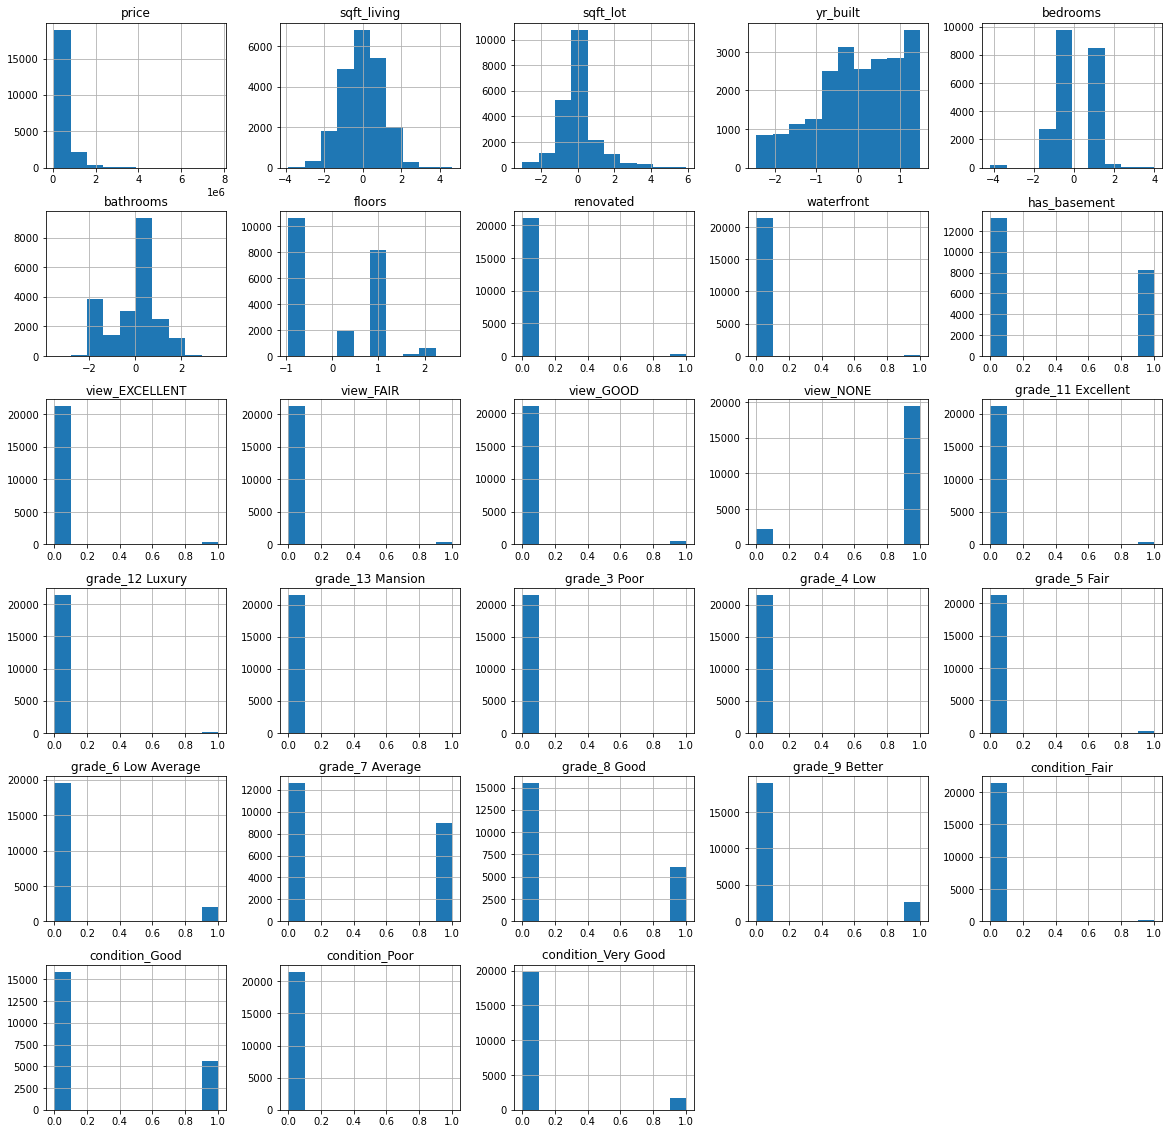

In [41]:
final_df.hist(figsize = (20,20));

In [42]:
final_df.to_csv('./data/preprocessed.csv')

## Modeling Data
Now we can preprocess our cleaned data and further explore features in order to prepare for modeling:

[Data Modeling Notebook](./kc_data_modeling.ipynb)